# Main

Implimenting the main model

## Imports

In [1]:
import nltk
import json
from nltk.stem import WordNetLemmatizer
from collections import Counter

import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import jaccard_similarity_score
from scipy import spatial
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
%matplotlib inline

import pickle

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
import nltk
import json
from collections import Counter

## Functions

In [3]:
# Simplified question
def getSimpleSentence(question, concat_words = False):
    text = nltk.word_tokenize(question)
    words = nltk.pos_tag(text)
#     print(words)
#     less_words = [wt for (wt, tag) in words if tag not in ["CC","DT","EX","IN","LS","POS","TO",".","\\",",",":","(",")"]]
    less_words = [wt for (wt, tag) in words if tag.startswith("J") or tag.startswith("V") or tag.startswith("N") or tag.startswith("R") ]
    return " ".join(less_words) if concat_words else less_words
getSimpleSentence("the ki\"tten's toy is black")

['ki', 'tten', 'toy', 'is', 'black']

In [4]:
def createCorpus(json_data):
    j = json_data
    corpus = []
    
    for data in j['data']:
        for paragraph in data["paragraphs"]:
            context = getSimpleSentence(paragraph["context"], True).lower()
            corpus.append(context)
            for q in paragraph["qas"]:
                question = getSimpleSentence(q["question"], True).lower()
                corpus.append(question)
    return corpus

In [5]:
# Make and load pickles
def makePickle(filename, data_file):
    pickle_out = open("pickles/" + filename + ".pickle","wb")
    pickle.dump(data_file, pickle_out)
    pickle_out.close()
    
def loadPickle(filename):
    pickle_in = open("pickles/" + filename + ".pickle","rb")
    return pickle.load(pickle_in)

In [6]:
# Jaccard Similarity function
def DistJaccard(str1, str2):
    str1 = set(str1)
    str2 = set(str2)
    jd = nltk.jaccard_distance(str1, str2)
#     manual = float(len(str1 & str2)) / len(str1 | str2)
    return jd

DistJaccard(getSimpleSentence("something stuped okay lol", True),getSimpleSentence("test this is a sentence", True))

0.6666666666666666

In [7]:
def lemmatize(dictonary, corpus):
    lemma = WordNetLemmatizer()
    corp = []
    for sentence in corpus:
        s = nltk.word_tokenize(sentence)
        sent = []
        for word in s:
            if dictonary[word] != None:
                nw = lemma.lemmatize(word.lower(), dictonary[word.lower()])
                sent.append(nw)
            else:
                sent.append(word)
        corp.append(" ".join(sent))
    return corp

In [8]:
def getPOS(corpus):
    text = nltk.word_tokenize(corpus)
    words = nltk.pos_tag(text)
    return words

In [9]:
def makePOSDict(corpus):
    pos = getPOS(" ".join(corpus))
    pos_dict = {}
    for (word, tag) in pos:
        # if tag.startswith("J"):
        # 	pos_dict[word] = wordnet.ADJ
        # elif tag.startswith("V"):
        # 	pos_dict[word] = wordnet.VERB
        # elif tag.startswith("N"):
        # 	pos_dict[word] = wordnet.NOUN
        # elif tag.startswith("R"):
        # 	pos_dict[word] = wordnet.ADV
        # else:
        # 	pos_dict[word] = ""

        wtag = tag[0].lower()
        wtag = wtag if wtag in ["a","r","n","v"] else None
        pos_dict[word] = wtag
        
    return pos_dict

## Process Data

In [10]:
with open('training.json') as f:
    json_data = json.load(f)

In [11]:
try:
    corpus = loadPickle('corpus')
except:
    corpus = createCorpus(json_data)
    makePickle('corpus', corpus)

In [12]:
try:
    pos_dict = loadPickle('pos_dic')
except:
    pos_dict = makePOSDict(corpus)
    makePickle('pos_dic', pos_dict)

In [13]:
try:
    corpus = loadPickle('corpus_lemmatize')
except:
    corpus = lemmatize(pos_dict, corpus)
    makePickle('corpus_lemmatize', corpus)

KeyError: 'u.n'

In [ ]:
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(corpus)
vectorsArrayForm = vectors.toarray()

In [26]:
# Get all similarity and output dict
pred = {}
similarity = {}
counter = 0
for obj in json_data["data"]:
    for para in obj["paragraphs"]:
        
        context_vector = vectorsArrayForm[counter]
#         getSimpleSentence(corpus[counter], True)
#         context = getSimpleSentence(para["context"], True)

        counter += 1
        for q in para["qas"]:
            question_id = q["id"]
            question_vector = vectorsArrayForm[counter]
#             question_vector = corpus[counter]
#             question = getSimpleSentence(q["question"], True)

            similarity[question_id] = jaccard_similarity_score(context_vector, question_vector)
#             similarity[question_id] = DistJaccard(context_vector, getSimpleSentence(question_vector, True))
#             similarity[question_id] = np.random.rand() * 0.5 + (0 if q["is_impossible"] else 0.5)

            pred[question_id] = 0 if q["is_impossible"] else 1
            counter += 1

In [27]:
# dict to array
y = []
x = []
for k,v in similarity.items():
    x.append(v)
    y.append(pred[k])

In [28]:
Y = np.array(y)
X = np.array(x).reshape(-1, 1)

In [29]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.10,random_state=0)
len(y), len(X), len(X_train),len(X_test),len(y_train),len(y_test)

(69596, 69596, 62636, 6960, 62636, 6960)

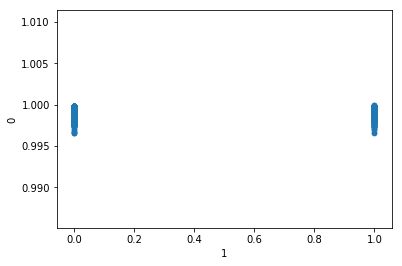

In [30]:
xy = np.array([x,y])
data = pd.DataFrame(data=np.transpose(xy))
data.head()
data.plot(kind='scatter', x=1, y=0)

## Logistic Regression

In [31]:
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression()

In [32]:
logisticRegr.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [33]:
y_pred=logisticRegr.predict(X_test)

In [34]:
data_pred = pd.DataFrame(data=y_pred)
data_test = pd.DataFrame(data=y_test)
data_pred[0].value_counts(), data_test[0].value_counts()

(1    6960
 Name: 0, dtype: int64, 0    3485
 1    3475
 Name: 0, dtype: int64)

In [35]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[   0, 3485],
       [   0, 3475]])

## Plot

Text(0.5, 257.44, 'Predicted label')

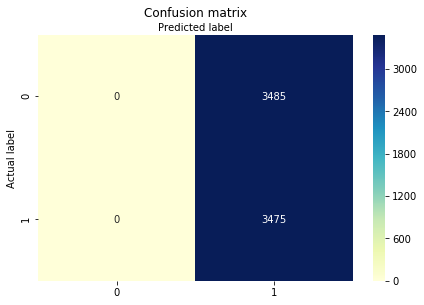

In [36]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [37]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F-Score:",metrics.f1_score(y_test, y_pred))

Accuracy: 0.4992816091954023
Precision: 0.4992816091954023
Recall: 1.0
F-Score: 0.6660277910876856


In [ ]:
# text = nltk.word_tokenize(data["data"][0]["paragraphs"][0]["context"])
text = nltk.word_tokenize("the ki\"tten's toy is black")
words = nltk.pos_tag(text)
tags = [tag for (wt, tag) in words]
# [wt for (wt, tag) in words if tag in ['NNP','VBD']]
words
# Counter(tags)

## Write to file

In [4]:
# with open('output.json', 'w') as outfile:  
#     json.dump(predictions, outfile)